# Evaluation

# Coverage / Time

In [97]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [98]:
resultspath = '../results/'
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [99]:
def convert_unixtime_deltaseconds(df, timecolumn='# unix_time'):
    df['date'] = pd.to_datetime(df[timecolumn],unit='s')
    df['delta_time'] = df['date']-df['date'][0]
    return df

def resample_timeseries(df, resample_freq, time_series_col='delta_time'):
    df = df.set_index(time_series_col).resample(resample_freq).mean().reset_index()
    return df.reset_index(drop=True)
    
def utest(dffinal, x_var='delta_time', y_var='cur_path', event1='AFL', event2='Curious_AFL'):
    dffinal2 = dffinal.groupby([x_var, 'event']).mean().reset_index()
    dffinal2_afl = dffinal2.loc[dffinal2['event']==event1][y_var]
    dffinal2_curious = dffinal2.loc[dffinal2['event']==event2][y_var]
    stat, p = mannwhitneyu(dffinal2_afl, dffinal2_curious)
    return np.round(p, 6)

## objdump - paths

In [100]:
exec_name = 'objdump'
dffinal = pd.DataFrame()

In [101]:
# afl
for trial in range(1,11):
    resultpath = os.path.join(resultspath + exec_name, exec_name + 'afl' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFL"
    dffinal = dffinal.append(df)

In [102]:
# aflfast
for trial in range(1,11):
    resultpath = os.path.join(resultspath + exec_name, exec_name + 'aflfast' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFLFast"
    dffinal = dffinal.append(df)

In [103]:
# curious
for trial in ['']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_pca' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "Curious_AFL2"
    dffinal = dffinal.append(df)

In [104]:
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur100' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "AflfastCurious100"
    dffinal = dffinal.append(df)
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur1000' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "AflfastCurious1000"
    dffinal = dffinal.append(df)
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur10000' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "AflfastCurious10000"
    dffinal = dffinal.append(df)
    
for trial in ['']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious_single' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "AflCuriousSingle"
    dffinal = dffinal.append(df)

In [105]:
dffinal['delta_time'] = dffinal['delta_time'].dt.total_seconds() / 3600

p = utest(dffinal)

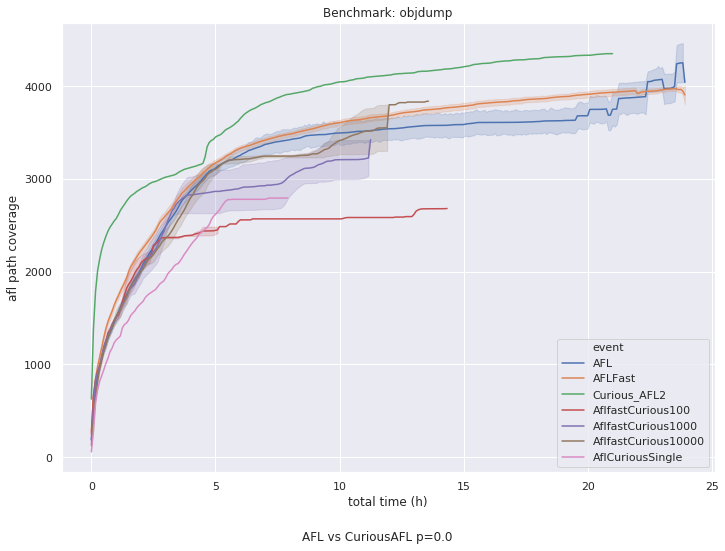

In [106]:
ax = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='total time (h)', ylabel='afl path coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h.png', dpi = 200)

## true coverage - BB coverage

In [187]:
exec_name = 'objdump'
dffinal = pd.DataFrame()

In [188]:
# afl
for trial in range(1,8):
    resultpath = os.path.join('./' + exec_name + '_afl' + str(trial)+ '_empty.csv')
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')

    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFL"
    dffinal = dffinal.append(df)

In [189]:
# aflfast
for trial in range(1,8):
    resultpath = os.path.join('./' + exec_name + '_aflfast' + str(trial)+ '_empty.csv')
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')


    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFLFast"
    dffinal = dffinal.append(df)

In [190]:
# curious
for trial in ['']:
    resultpath = os.path.join('./' + exec_name + '_curious' + str(trial)+ '_empty.csv')
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
    df = df[['total_coverage', 'delta_time']]
    df = resample_timeseries(df, '5T', time_series_col='delta_time')


    df = df[['delta_time', 'total_coverage']]
    df = df.rename(columns={'total_coverage': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "Curious_AFL"
    dffinal = dffinal.append(df)

In [191]:
# neuzz
resultpath = os.path.join('./objdump_neuzz_empty.csv')
df = pd.read_csv(resultpath)


df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
df = df[['total_coverage', 'delta_time']]
df = resample_timeseries(df, '5T', time_series_col='delta_time')


df = df[['delta_time', 'total_coverage']]
df = df.rename(columns={'total_coverage': 'cur_path'})
df['cur_path'] =df['cur_path'].ffill()

df['event'] = "NEUZZ"
dffinal = dffinal.append(df)

In [192]:
dffinal = dffinal.loc[dffinal['delta_time']<'24:00:00']

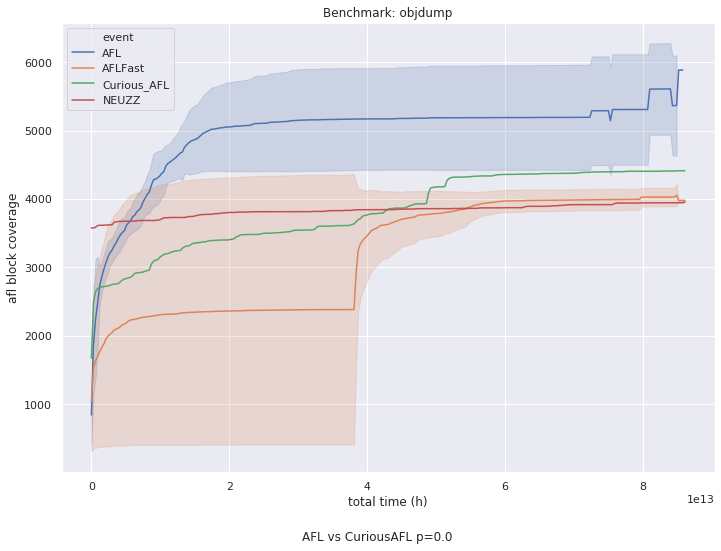

In [193]:
ax = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci="sd", data=dffinal)
ax.set(xlabel='total time (h)', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'_BBcoverage_24h.png', dpi = 200)

In [118]:
resultpath = os.path.join(resultspath + exec_name, exec_name + 'afl1')
df = pd.read_csv(resultpath)

df = convert_unixtime_deltaseconds(df)


In [120]:
df = resample_timeseries(df, '5T')

In [121]:
df

,delta_time,# unix_time,cycles_done,cur_path,paths_total,pending_total,pending_favs,unique_crashes,unique_hangs,max_depth,execs_per_sec
0,00:00:00,1.567630e+09,0.0,63.543860,165.771930,127.789474,58.280702,0.0,0.0,4.298246,3133.584035
1,00:05:00,1.567630e+09,0.0,193.203390,446.169492,341.474576,119.406780,0.0,0.0,5.779661,3193.646271
2,00:10:00,1.567630e+09,0.0,303.250000,631.522727,483.363636,138.931818,0.0,0.0,6.000000,1282.750682
3,00:15:00,1.567631e+09,0.0,405.436364,920.545455,745.600000,164.054545,0.0,0.0,6.600000,2690.774182
4,00:20:00,1.567631e+09,0.0,495.641509,1026.849057,801.528302,140.415094,0.0,0.0,7.000000,2342.810943
...,...,...,...,...,...,...,...,...,...,...,...
272,22:40:00,1.567711e+09,2.0,4327.600000,4377.900000,3015.600000,4.100000,82.0,0.0,43.000000,520.002000
273,22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
274,22:50:00,1.567712e+09,2.0,4345.666667,4385.666667,3021.333333,3.666667,82.0,0.0,43.000000,2049.026667
275,22:55:00,1.567712e+09,2.0,4351.000000,4388.000000,3023.000000,3.000000,82.0,0.0,43.000000,1459.120000


## unique_crashes

In [107]:
exec_name = 'objdump'
dffinal = pd.DataFrame()

In [108]:
# afl
for trial in range(1,11):
    resultpath = os.path.join(resultspath + exec_name, exec_name + 'afl' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()
    
    df['event'] = "AFL"
    dffinal = dffinal.append(df)

In [109]:
# aflfast
for trial in range(1,11):
    resultpath = os.path.join(resultspath + exec_name, exec_name + 'aflfast' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()
    
    df['event'] = "AFLFast"
    dffinal = dffinal.append(df)

In [110]:
# curious
for trial in ['']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_pca' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()

    df['event'] = "Curious_AFL2"
    dffinal = dffinal.append(df)

In [111]:
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur100' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()

    df['event'] = "AflfastCurious100"
    dffinal = dffinal.append(df)
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur1000' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()

    df['event'] = "AflfastCurious1000"
    dffinal = dffinal.append(df)
for trial in ['', '2']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_fastcur10000' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()

    df['event'] = "AflfastCurious10000"
    dffinal = dffinal.append(df)
    
for trial in ['']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious_single' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()

    df['event'] = "AflCuriousSingle"
    dffinal = dffinal.append(df)

In [112]:
dffinal['delta_time'] = dffinal['delta_time'].dt.total_seconds() / 3600

p = utest(dffinal, y_var='unique_crashes')

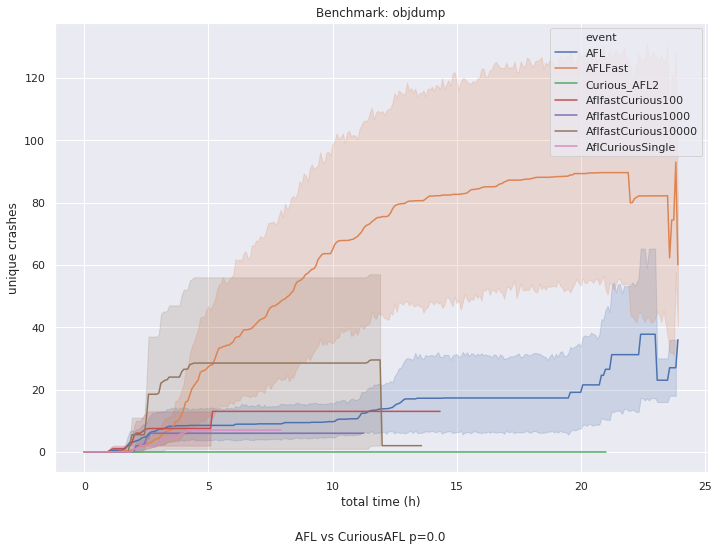

In [116]:
ax = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=90, data=dffinal)
ax.set(xlabel='total time (h)', ylabel='unique crashes')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'_crashes_24h.png', dpi = 200)

## nm

In [208]:
exec_name = 'nm'
dffinal = pd.DataFrame()

In [209]:
# afl
for trial in ['1','2', '3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + 'afl' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    
    df['event'] = "AFL"
    dffinal = dffinal.append(df)

In [210]:
# curious
for trial in ['1', '3']:

    resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious' + str(trial))
    df = pd.read_csv(resultpath)

    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')

    df = df[['delta_time', ' paths_total']]
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()

    df['event'] = "Curious_AFL"
    dffinal = dffinal.append(df)

In [211]:
# neuzz
resultpath = os.path.join('./nm_neuzz_empty.csv')
df = pd.read_csv(resultpath)


df = convert_unixtime_deltaseconds(df, timecolumn='m_timestamp')
df = df[['total_coverage', 'delta_time']]
df = resample_timeseries(df, '5T', time_series_col='delta_time')


df = df[['delta_time', 'total_coverage']]
df = df.rename(columns={'total_coverage': 'cur_path'})
df['cur_path'] =df['cur_path'].ffill()

df['event'] = "NEUZZ"
dffinal = dffinal.append(df)

In [212]:
dffinal['delta_time'] = dffinal['delta_time'].dt.total_seconds() / 3600

p = utest(dffinal)

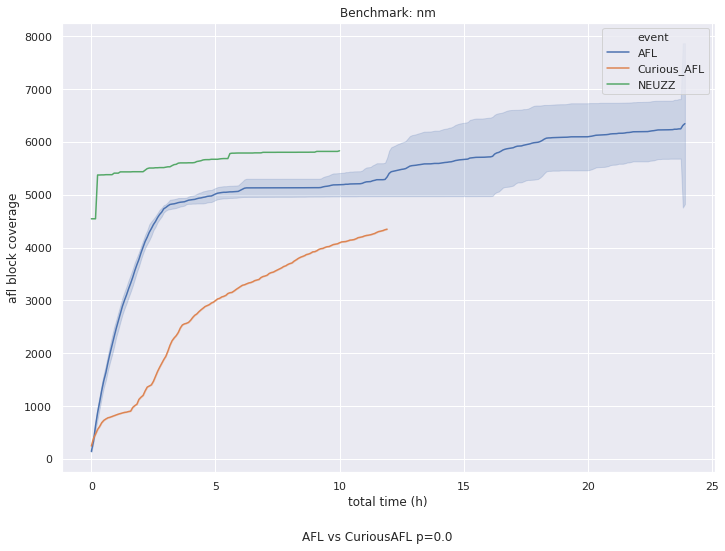

In [213]:
ax = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='total time (h)', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h.png', dpi = 200)

## unique_crashes

In [148]:
exec_name = 'nm'
dffinal = pd.DataFrame()

In [149]:
# afl
for trial in ['1','2', '3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_afl' + str(trial))
    df = pd.read_csv(resultpath)
    
    df = convert_unixtime_deltaseconds(df)
    df = resample_timeseries(df, '5T')
    
    df = df[['delta_time', ' unique_crashes']]
    df = df.rename(columns={' unique_crashes': 'unique_crashes'})
    df['unique_crashes'] =df['unique_crashes'].ffill()
    
    df['event'] = "AFL"
    dffinal = dffinal.append(df)

In [150]:
# curious
resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious2')
df = pd.read_csv(resultpath)

df = convert_unixtime_deltaseconds(df)
df = resample_timeseries(df, '5T')

df = df[['delta_time', ' unique_crashes']]
df = df.rename(columns={' unique_crashes': 'unique_crashes'})
df['unique_crashes'] =df['unique_crashes'].ffill()

df['event'] = "Curious_AFL"
dffinal = dffinal.append(df)

In [151]:
dffinal['delta_time'] = dffinal['delta_time'].dt.total_seconds() / 3600

p = utest(dffinal, y_var='unique_crashes')

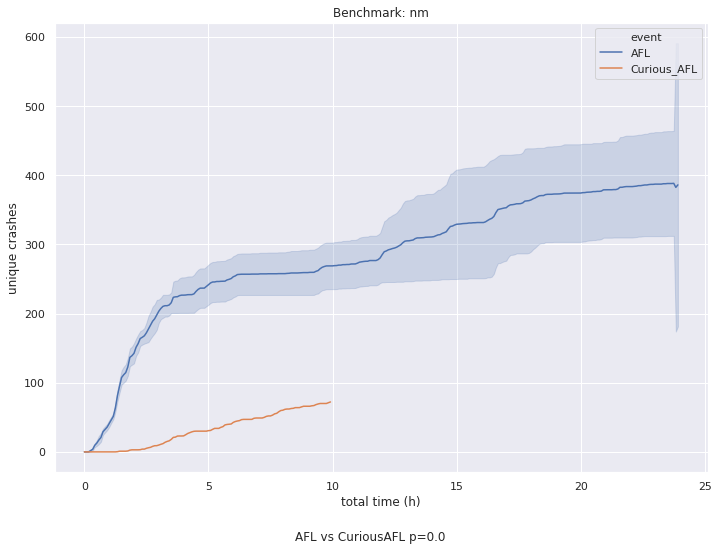

In [152]:
ax = sns.lineplot(x="delta_time", y="unique_crashes", hue='event', ci=60, data=dffinal)
ax.set(xlabel='total time (h)', ylabel='unique crashes')

plt.legend()
plt.title('Benchmark: ' + exec_name)
#plt.text(3+0.2, 4.5, "AFLvsCuriousAFL p=" + str(p), horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'_crashes_24h.png', dpi = 200)

# Coverage / Executions

## objdump

In [153]:
exec_name = 'objdump'
dffinal = pd.DataFrame()

In [154]:
for trial in ['1','2','3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_afl' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]
    
    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    #df = df.rename(columns={' paths_total': 'cur_path'})
    #del df['running_exec_sum']
    df['event'] = 'AFL'
    dffinal = dffinal.append(df)

In [155]:
# curious
for trial in ['', '1']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]

    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    df['event'] = 'CuriousAFL'
    dffinal = dffinal.append(df)


In [156]:
p = utest(dffinal, x_var='running_exec_sum')

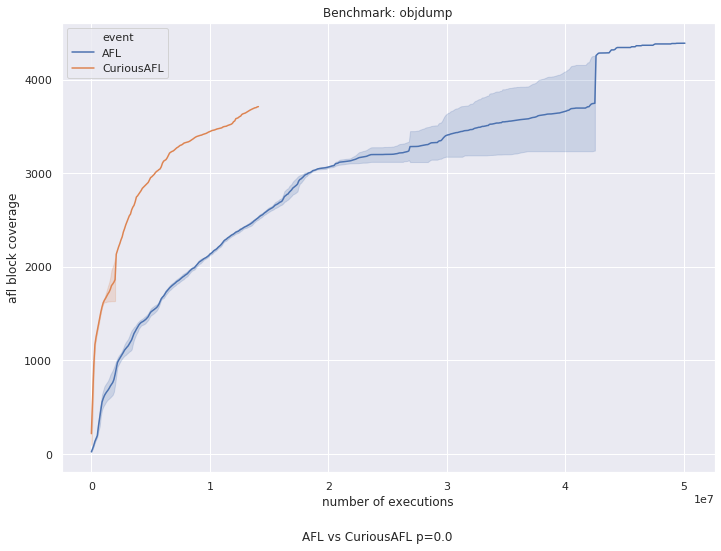

In [157]:
ax = sns.lineplot(x="running_exec_sum", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='number of executions', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h_covtime.png', dpi = 200)

## nm

In [163]:
exec_name = 'nm'
dffinal = pd.DataFrame()

In [164]:
for trial in ['1','2','3']:
    resultpath = os.path.join(resultspath + exec_name, exec_name + '_afl' + str(trial))
    df = pd.read_csv(resultpath)
    df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
    df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
    df_helper.set_index(0, inplace=True)
    del df_helper['# unix_time']
    df_helper[' execs_per_sec'].ffill(inplace=True)
    df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
    df_helper = df_helper[[' paths_total', 'running_exec_sum']]
    
    df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
    df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
    df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
    df = df.rename(columns={' paths_total': 'cur_path'})
    df['cur_path'] =df['cur_path'].ffill()
    #df = df.rename(columns={' paths_total': 'cur_path'})
    #del df['running_exec_sum']
    df['event'] = 'AFL'
    dffinal = dffinal.append(df)

In [165]:
# curious
resultpath = os.path.join(resultspath + exec_name, exec_name + '_curious2')
df = pd.read_csv(resultpath)
df_helper = pd.DataFrame(np.array(range(df['# unix_time'][0], df['# unix_time'][len(df)-1]+1)))
df_helper = df_helper.merge(df[['# unix_time', ' execs_per_sec', ' paths_total']], left_on=0, right_on='# unix_time', how='left', left_index=True)
df_helper.set_index(0, inplace=True)
del df_helper['# unix_time']
df_helper[' execs_per_sec'].ffill(inplace=True)
df_helper['running_exec_sum'] = df_helper[' execs_per_sec'].cumsum()
df_helper = df_helper[[' paths_total', 'running_exec_sum']]

df_helper['running_exec_sum'] = pd.to_datetime(df_helper['running_exec_sum'], unit='s', origin='unix')
df = df_helper.set_index('running_exec_sum').resample('100000s').mean().reset_index()
df['running_exec_sum'] = df.running_exec_sum.astype(int) / 10**9
df = df.rename(columns={' paths_total': 'cur_path'})
df['cur_path'] =df['cur_path'].ffill()
df['event'] = 'CuriousAFL'
dffinal = dffinal.append(df)


In [166]:
p = utest(dffinal, x_var='running_exec_sum')

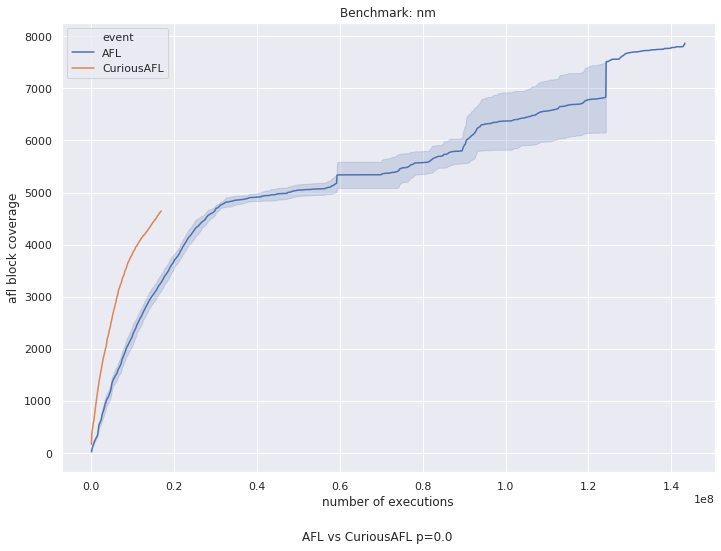

In [167]:
ax = sns.lineplot(x="running_exec_sum", y="cur_path", hue='event', ci=60, data=dffinal)
ax.set(xlabel='number of executions', ylabel='afl block coverage')

plt.legend()
plt.title('Benchmark: ' + exec_name)
plt.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig('./'+exec_name+'24h_covtime.png', dpi = 200)